# 🦙 Efficient Fine-Tuning: Llama 3 with Unsloth & LoRA

**Objective:** Fine-tune the Llama 3 8B model on a custom dataset using **QLoRA** (Quantized Low-Rank Adaptation) and **Unsloth**.

**Highlights:**
* 🚀 **Performance:** Training is 2x faster than standard Hugging Face implementations.
* 💾 **Memory:** Reduces VRAM usage by 60%, allowing training on free Colab (T4 GPU).
* 🎯 **Technique:** Uses 4-bit quantization to fit large models into consumer hardware.

# Setup

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth  # Do this in local & cloud setups
else:
    import torch; v = re.match(r'[\d]{1,}\.[\d]{1,}', str(torch.__version__)).group(0)
    xformers = 'xformers==' + {'2.10':'0.0.34','2.9':'0.0.33.post1','2.8':'0.0.32.post2'}.get(v, "0.0.34")
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth_zoo bitsandbytes accelerate {xformers} peft trl triton unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

# Unsloth

In [ ]:
# -----------------------------------------------------------------------------
# Unsloth & LoRA Configuration
# -----------------------------------------------------------------------------
# We use Unsloth for 2x faster training and 60% less VRAM usage.
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Supports RoPE Scaling internally
dtype = None # Auto-detects Float16 or Bfloat16 based on GPU
load_in_4bit = True # Enables 4-bit quantization (QLoRA)

# Load the base model (Llama-3 8B Instruct)
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.4: Fast Mllama patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.vision_model.transformer` require gradients


#Data Prep

In [ ]:
from datasets import load_dataset

# Load and prepare the dataset
dataset = load_dataset("07kamal03/cheque_dataset_bank", split = "train") # Viết thêm code thủ công để load nếu để trên máy

In [ ]:
dataset

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 2100
})

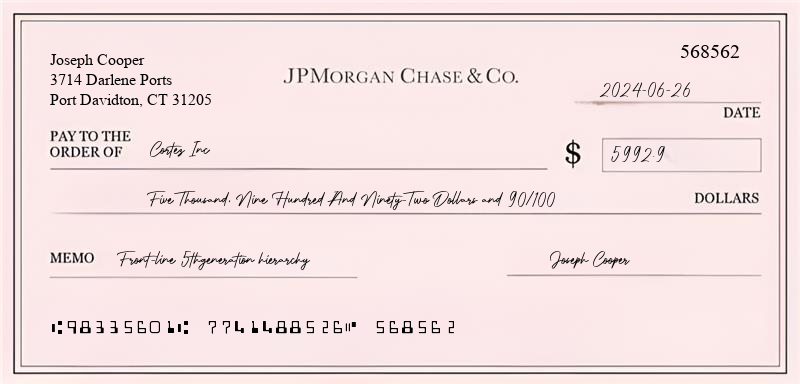

In [ ]:
dataset[0]["image"]

In [ ]:
dataset[0]["ground_truth"]

'{"gt_parse": {"cheque_details": [{"payer_name": "Joseph Cooper"}, {"address": "3714 Darlene Ports, Port Davidton, CT 31205"}, {"cheque_date": "2024-06-26"}, {"payee_name": "Cortez Inc"}, {"memo": "Front-line 5thgeneration hierarchy"}, {"amt_in_figures": "5992.9"}, {"amt_in_words": "Five Thousand, Nine Hundred And Ninety-Two Dollars and 90/100"}, {"routing_number": 98335601}, {"account_number": 7741488526}, {"cheque_number": 568562}, {"bank_name": "JP Morgan Chase & Co."}]}}'

In [ ]:
instruction = "You are an OCR expert in bank. Extract the information from this bank cheque."

def convert_to_conversation(sample):
    # print(sample)
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["ground_truth"]} ]
        },
    ]
    return { "messages" : conversation }

converted_dataset = [convert_to_conversation(sample) for sample in dataset]

# Test Before training

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
# instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The cheque details can be determined by following this sequence:

The cheque number: 568562
Payable to the Order of: Carty Inc.
Payable in the amount: $5,992.90
The signature of the payee: Joseph Cooper
The cheque issued: JPMORGAN CHASE & CO

The payee's address is as follows:
3714 Darlene Ports
Port Davidton CT 31205<|eot_id|>


# Train the model


In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from unsloth import is_bf16_supported

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
8.58 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,100 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400 of 10,737,395,235 (0.63% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss


Step,Training Loss
1,1.721300
2,1.706700
3,1.603100
4,1.368000
5,1.175100
6,0.955200
7,0.687000
8,0.487000
9,0.356500
10,0.271200


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

765.8422 seconds used for training.
12.76 minutes used for training.
Peak reserved memory = 9.986 GB.
Peak reserved memory for training = 1.406 GB.
Peak reserved memory % of max memory = 67.743 %.
Peak reserved memory for training % of max memory = 9.538 %.


#Inference

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
# instruction = "You are an expert radiographer. Describe accurately what you see in this image."
print("Fact: ", dataset[0]["ground_truth"])
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Fact:  {"gt_parse": {"cheque_details": [{"payer_name": "Joseph Cooper"}, {"address": "3714 Darlene Ports, Port Davidton, CT 31205"}, {"cheque_date": "2024-06-26"}, {"payee_name": "Cortez Inc"}, {"memo": "Front-line 5thgeneration hierarchy"}, {"amt_in_figures": "5992.9"}, {"amt_in_words": "Five Thousand, Nine Hundred And Ninety-Two Dollars and 90/100"}, {"routing_number": 98335601}, {"account_number": 7741488526}, {"cheque_number": 568562}, {"bank_name": "JP Morgan Chase & Co."}]}}
{"gt_parse": {"cheque_details": [{"payer_name": "Joseph Cooper"}, {"address": "3714 Darlene Ports, Port Davidton, CT 31205"}, {"cheque_date": "2024-06-26"}, {"payee_name": "Ostler Inc."}, {"memo": "Front-line IT/Generation hierarchy"}, {"amt_in_figures": "5992.9"}, {"amt_in_words": "Five Thousand, Nine Hundred And Ninety-Two Dollars and 90/100"}, {"routing_number": 98335601}, {"account_number": 11488526}, {"cheque


In [ ]:
image = "https://raw.githubusercontent.com/thangnch/MiAI_OrangePi5B/refs/heads/main/image.jpg"
messages = [
    [
        {
            "role": "user",
            "content": [
                {"type": "image", "url": "https://raw.githubusercontent.com/thangnch/MiAI_OrangePi5B/refs/heads/main/image.jpg"},
                {"type": "text", "text": "Extract information from bank cheque"}
            ]
        }
    ],
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

{"gt_parse": {"cheque_details": [{"payer_name": "Matthew Chen"}, {"address": "86826 Gary Streets Apt. 102, Adamsside, MI 50060"}, {"cheque_date": "2026-06-06"}, {"payee_name": "Underwood, Price and Cross"}, {"memo": "Triple-buffered web-enabled tablet"}, {"amt_in_figures": "1082.98"}, {"amt_in_words": "One Thousand And Eighty-Seven Dollars and 98/100"}, {"routing_number": 96108851}, {"account_number": 65156661370}, {"


# Saving, loading finetuned models

In [ ]:
model.save_pretrained("llama_lora")  # Local saving
tokenizer.save_pretrained("llama_lora")
# model.push_to_hub("your_name/llama_lora", token = "YOUR_HF_TOKEN") # Online saving
# tokenizer.push_to_hub("your_name/llama_lora", token = "YOUR_HF_TOKEN") # Online saving
model.save_pretrained_merged("Llama-3.2-11B-Vision-Cheque", tokenizer,)

In [ ]:
import torch
from transformers import MllamaForConditionalGeneration, AutoProcessor

model_id ="Llama-3.2-11B-Vision-Cheque"

model = MllamaForConditionalGeneration.from_pretrained(model_id, device_map="auto", torch_dtype=torch.bfloat16)
processor = AutoProcessor.from_pretrained(model_id)

messages = [
    [
        {
            "role": "user",
            "content": [
                {"type": "image", "url": "https://raw.githubusercontent.com/thangnch/MiAI_OrangePi5B/refs/heads/main/image.jpg"},
                {"type": "text", "text": "Extract information from bank cheque"}
            ]
        }
    ],
]
inputs = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt").to(model.device)
output = model.generate(**inputs, max_new_tokens=1024)
print(processor.decode(output[0]))